## Cleaning the Fake News Corpus


In [16]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import cleantext
import matplotlib.pyplot as plt

# Task 1:
url = "https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv"
df = pd.read_csv(url)

def clean_content(text):
    cleaned_text = cleantext.clean(text,
                                   lower=True,
                                   no_urls=True,
                                   no_emails=True,
                                   no_phone_numbers=True,
                                   no_numbers=True,
                                   no_digits=True,
                                   no_currency_symbols=True,
                                   no_punct=True,
                                   replace_with_url="<URL>",
                                   replace_with_email="<EMAIL>",
                                   replace_with_phone_number="<PHONE>",
                                   replace_with_number="<NUM>",
                                   replace_with_digit="<NUM>",
                                   replace_with_currency_symbol="<CUR>")
    return cleaned_text

df['clean_content'] = df['content'].apply(clean_content)

# Tokenize the text
df['tokens'] = df['clean_content'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens_no_stopwords'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Stemming
ss = SnowballStemmer('english')
df['tokens_stemmed'] = df['tokens_no_stopwords'].apply(lambda tokens: [ss.stem(token) for token in tokens])





## Computing the vocabulary size before and after

In [17]:
def compute_vocabulary_size(tokens_list):
    unique_words = set()
    for tokens in tokens_list:
        unique_words.update(tokens)
    return len(unique_words)

# Compute vocabulary size before removing stopwords
original_vocabulary_size = compute_vocabulary_size(df['tokens'])
print(f"Original vocabulary size: {original_vocabulary_size}")

# Compute vocabulary size after removing stopwords
reduced_vocabulary_size_no_stopwords = compute_vocabulary_size(df['tokens_no_stopwords'])
print(f"Vocabulary size after removing stopwords: {reduced_vocabulary_size_no_stopwords}")

# Compute reduction rate of the vocabulary size after removing stopwords
reduction_rate_no_stopwords = (original_vocabulary_size - reduced_vocabulary_size_no_stopwords) / original_vocabulary_size * 100
print(f"Reduction rate after removing stopwords: {reduction_rate_no_stopwords:.2f}%")

# Compute vocabulary size after stemming
reduced_vocabulary_size_stemmed = compute_vocabulary_size(df['tokens_stemmed'])
print(f"Vocabulary size after stemming: {reduced_vocabulary_size_stemmed}")

# Compute reduction rate of the vocabulary size after stemming
reduction_rate_stemmed = (original_vocabulary_size - reduced_vocabulary_size_stemmed) / original_vocabulary_size * 100
print(f"Reduction rate after stemming: {reduction_rate_stemmed:.2f}%")




Original vocabulary size: 16499
Vocabulary size after removing stopwords: 16367
Reduction rate after removing stopwords: 0.80%
Vocabulary size after stemming: 10845
Reduction rate after stemming: 34.27%


## Exploring the dataset

Total number of URLs: 502
Total number of dates: 753
Total number of numeric values: 27668


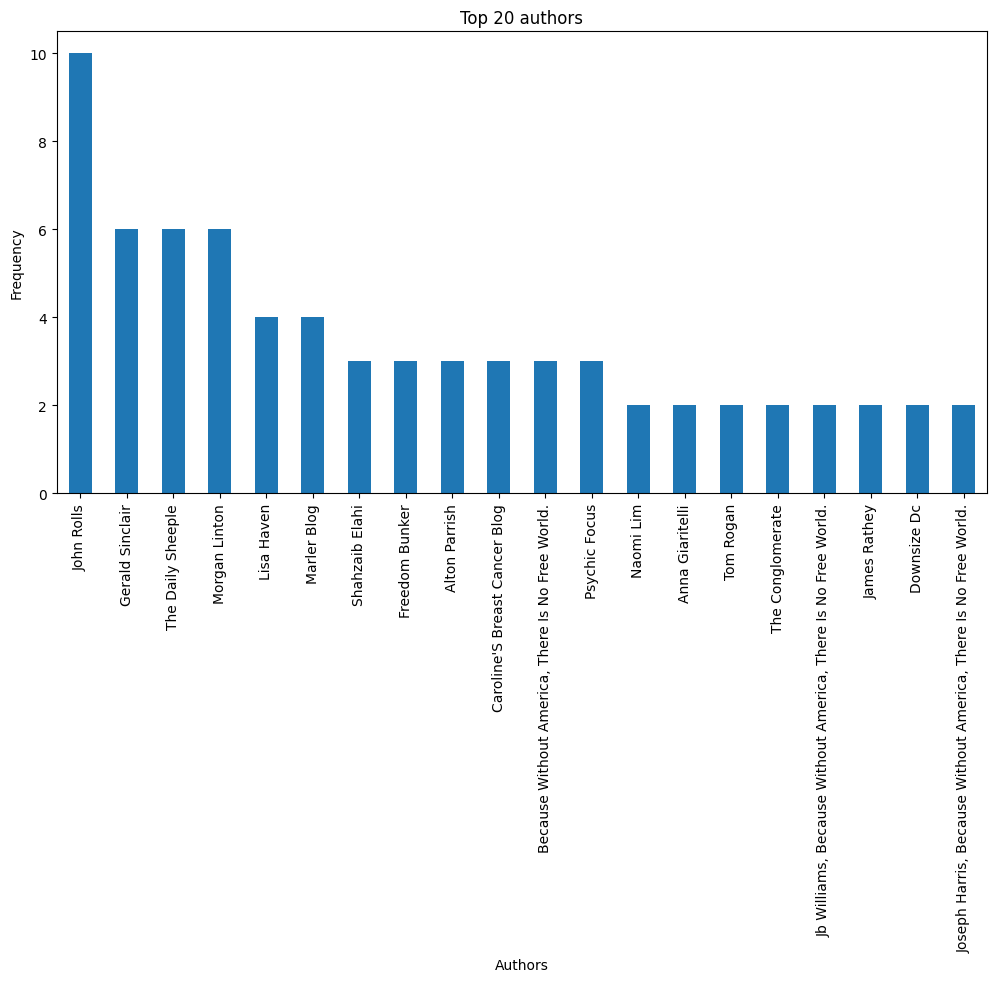

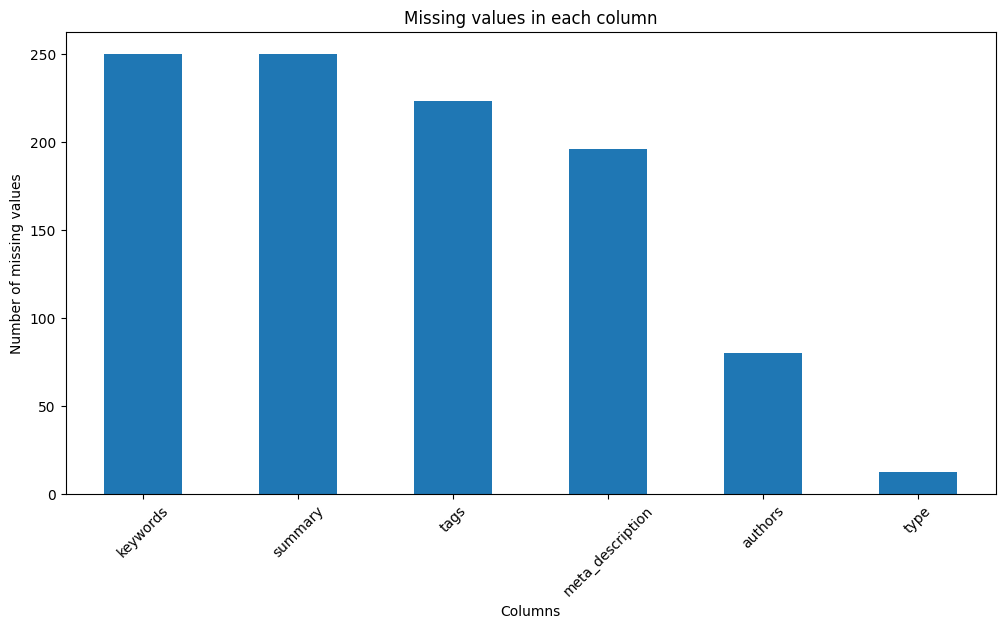

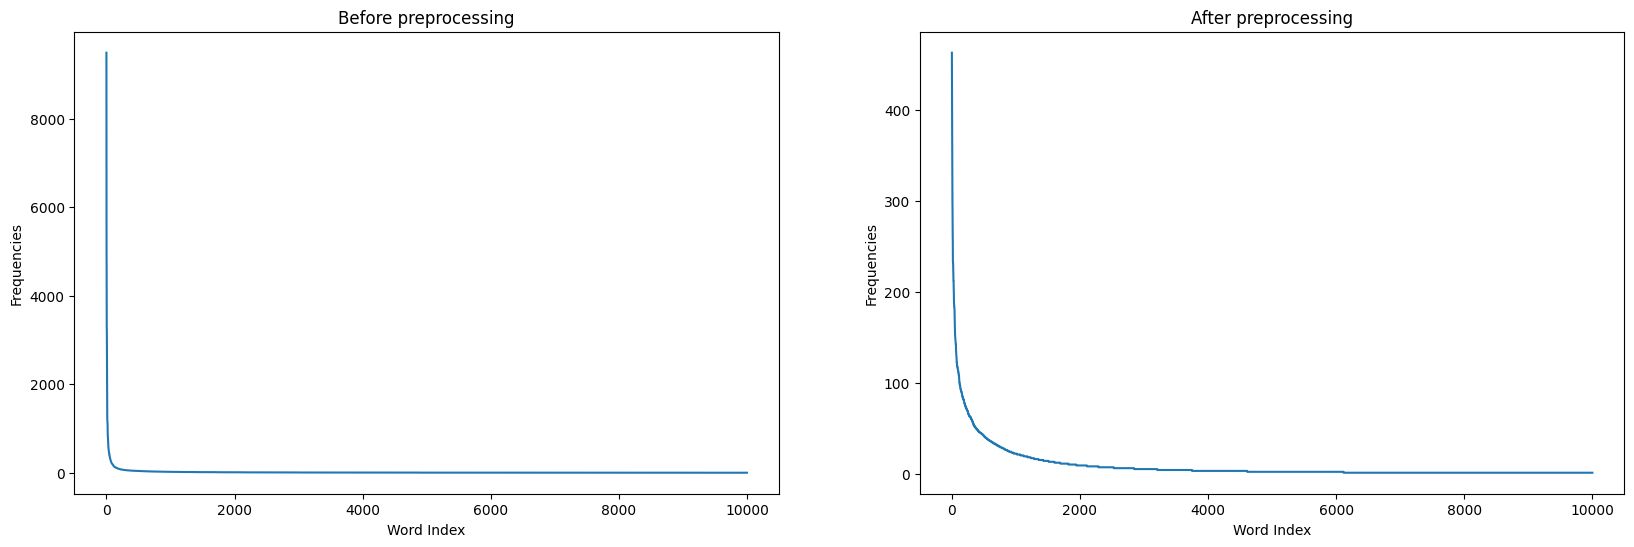

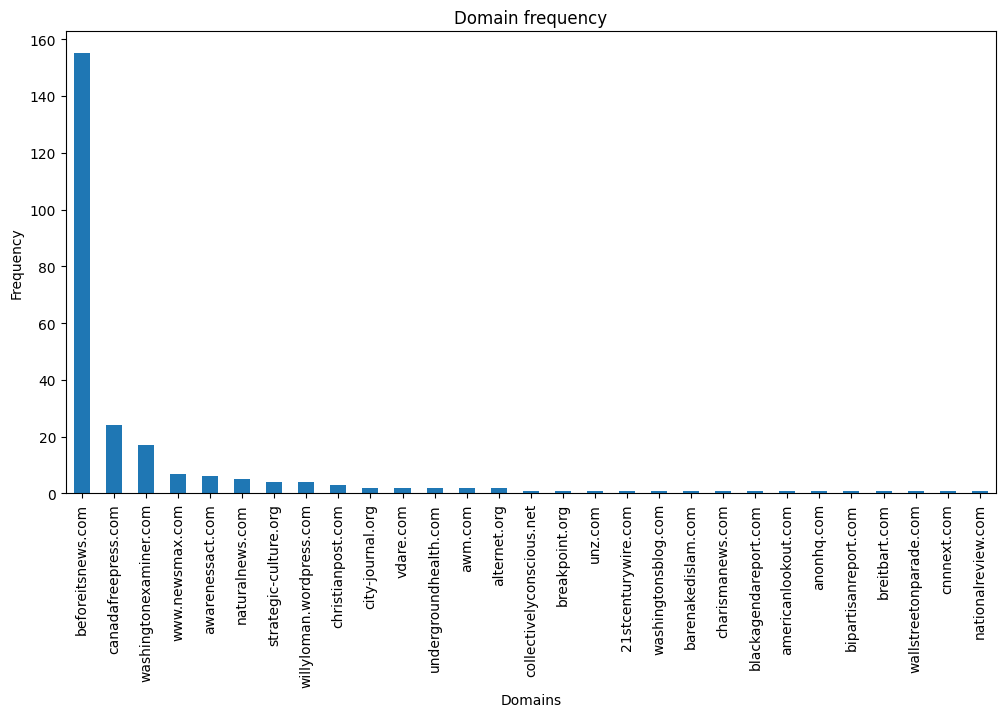

Average number of tokens per article before preprocessing: 707.92
Average number of tokens per article after preprocessing: 414.20


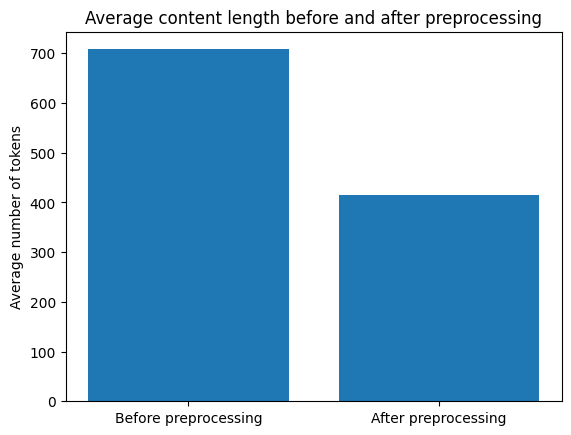

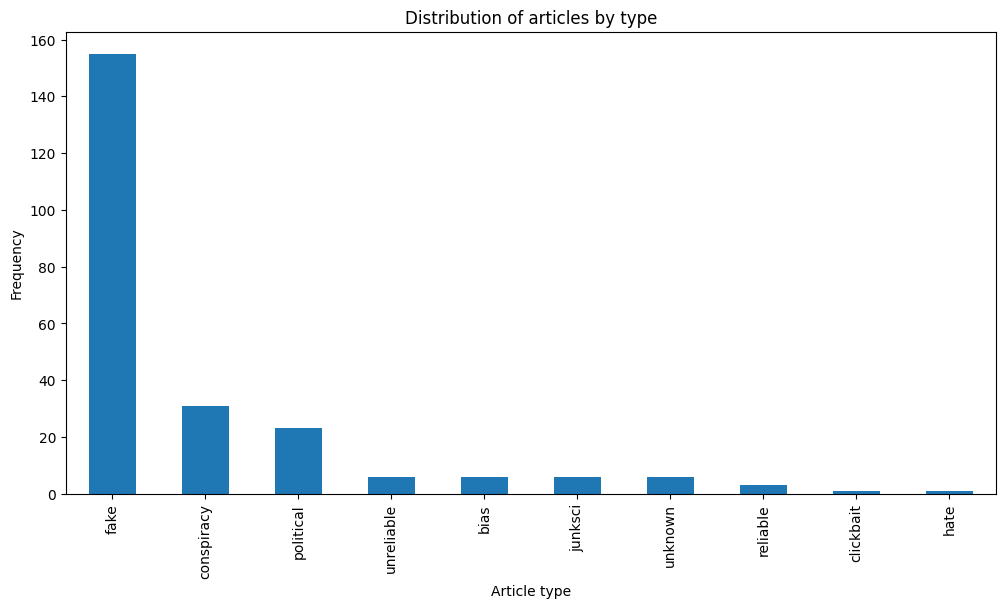

In [18]:
import re
import numpy as np
def count_elements(row):
    # Combines all text columns
    combined_text = ' '.join(row.astype(str))

    # Here we count the URL's
    url_pattern = r'(?:http[s]?://|www\.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 
    urls = re.findall(url_pattern, combined_text)
    url_count = len(urls)

    # Here we count dates
    date_pattern = r'\d{4}-\d{2}-\d{2}'
    dates = re.findall(date_pattern, combined_text)
    date_count = len(dates)

    # Here we count the numeric values
    numeric_pattern = r'\d'
    numeric_values = re.findall(numeric_pattern, combined_text)
    numeric_count = len(numeric_values)

    return url_count, date_count, numeric_count

# Here we save the results to a new column
df['url_count'], df['date_count'], df['numeric_count'] = zip(*df.apply(count_elements, axis=1))

# Here we save sum up the number for each of the columns
total_urls = df['url_count'].sum()
total_dates = df['date_count'].sum()
total_numeric_values = df['numeric_count'].sum()

print(f"Total number of URLs: {total_urls}")
print(f"Total number of dates: {total_dates}")
print(f"Total number of numeric values: {total_numeric_values}")

# Here we count the frequency of the top 20 authors
author_counts = df['authors'].value_counts()

plt.figure(figsize=(12, 6))
author_counts.head(20).plot(kind='bar')
plt.xlabel("Authors")
plt.ylabel("Frequency")
plt.title("Top 20 authors")
plt.show()

# Here we calculate the number of missing values in each column
missing_values = df.isnull().sum()
sorted_missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_missing_values.head(6).plot(kind='bar') #We started off by plotting for each column, but only the first 5 (in the sorted) are interesting as the others are 0.
plt.xlabel("Columns")
plt.ylabel("Number of missing values")
plt.title("Missing values in each column")
plt.xticks(rotation=45)
plt.show()

def count_word_frequencies(df, ignore_words=None):
    word_freq = {}
    for tokens in df:
        for word in tokens:
            if ignore_words and word.lower() in ignore_words:
                continue
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

    items = list(word_freq.items())
    items.sort(reverse=True, key=lambda x: x[1])

    top_word_freq = items[:10000]
    return top_word_freq

# Before removing stopwords and applying stemming
top10000_before = count_word_frequencies(df['tokens'])

# After removing stopwords and applying stemming
top10000_after = count_word_frequencies(df['tokens_stemmed'], ignore_words=['url', 'num', 'email', 'phone', 'cur', '<', '>'])

words_before = [word[0] for word in top10000_before]
freq_before = [freq[1] for freq in top10000_before]

words_after = [word[0] for word in top10000_after]
freq_after = [freq[1] for freq in top10000_after]

# Here we plot the top 10,000 most frequent words before and after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(freq_before)
ax1.set_xlabel("Word Index")
ax1.set_ylabel("Frequencies")
ax1.set_title("Before preprocessing")

ax2.plot(freq_after)
ax2.set_xlabel("Word Index")
ax2.set_ylabel("Frequencies")
ax2.set_title("After preprocessing")

plt.show()

# Additional statistics and visualizations

# Distribution of domains
domain_counts = df['domain'].value_counts()

plt.figure(figsize=(12, 6))
domain_counts.plot(kind='bar')
plt.xlabel("Domains")
plt.ylabel("Frequency")
plt.title("Domain frequency")
plt.show()

# Here we calculate the average number of tokens before and after preprocessing
df['content_length_before'] = df['tokens'].apply(len)
df['content_length_after'] = df['tokens_stemmed'].apply(len)

avg_before = np.mean(df['content_length_before'])
avg_after = np.mean(df['content_length_after'])

print(f"Average number of tokens per article before preprocessing: {avg_before:.2f}")
print(f"Average number of tokens per article after preprocessing: {avg_after:.2f}")

# Here we create a bar chart to visualize the difference
plt.bar(['Before preprocessing', 'After preprocessing'], [avg_before, avg_after])
plt.ylabel("Average number of tokens")
plt.title("Average content length before and after preprocessing")
plt.show()

# Here we count number of articles in each category
type_counts = df['type'].value_counts()
plt.figure(figsize=(12, 6))
type_counts.plot(kind='bar')
plt.xlabel("Article type")
plt.ylabel("Frequency")
plt.title("Distribution of articles by type")
plt.show()




## Cleaning data and saving to a new CSV-file

In [19]:
# # Task 3. For this task we only manipulate the 'content' column. We overwrite this, as mentioned in the report, due to the fact that we do not need the original 'content' column for anything
# data = pd.read_csv('news_sample.csv', engine="python")

# # Here we apply our clean_content function defined in task 1
# data['content'] = data['content'].apply(clean_content)

# # Here we tokenize our text
# data['content'] = data['content'].apply(word_tokenize)

# # Here we remove the stopwords
# data['content'] = data['content'].apply(lambda tokens: [token for token in tokens if token not in stop_words])


# # Here we apply stemming 
# data['content'] = data['content'].apply(lambda tokens: [ss.stem(token) for token in tokens])

# # Here we save the resulting dataframe to a new csv file, which we use throughout the assignment
# data.to_csv('news_sample_cleaned2.csv', index=False)



# Loading the data

In [20]:
df_large = pd.read_csv('news_sample_cleaned2.csv', nrows=100000)

df_large.fillna('', inplace=True)

In [21]:
# Part 1, task 4
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# This is part of part 2 task 0
df_large['label'] = df_large['type'].apply(lambda x: 'reliable' if x in ['reliable', 'political'] else 'fake')

# This is part of part 2 task 1
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_large['content'])
y = df_large['label']

# Here we split the dataset into training, validation, and test sets. We, as mentioned, complete some of part 2 in this task, as we thought it was obvious to do here.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Part 2


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Here we define our simple models that we want to use for this task
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, C=10, penalty='l2')),
    ('Naive Bayes', MultinomialNB(alpha=0.1)),
    ('Support Vector Machine', LinearSVC(max_iter=1000, C=10, penalty='l2'))
]
 
# Here we calculate the accuracy of each model using accuracy_score
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {accuracy:.4f}")





Logistic Regression accuracy: 0.9130
Naive Bayes accuracy: 0.8437
Support Vector Machine accuracy: 0.9100


## Performing GridSearch

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Here we define the range of hyperparameters to search over when running GridSearch
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Here we create a grid search object and fit it to the training data
lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Validation accuracy:", grid_search.best_score_)


# Here we define the hyperparameters for the Naive Bayes classifier
nb_params = {'alpha': [0.1, 0.5, 1.0]}

# Here we create a Naive Bayes classifier with the hyperparameters
nb = MultinomialNB()
nb_grid_search = GridSearchCV(nb, nb_params, cv=5)
nb_grid_search.fit(X_train, y_train)

print("Naive Bayes best hyperparameters:", nb_grid_search.best_params_)
print("Validation accuracy:", nb_grid_search.best_score_)

# We define some relevant parameters for the Support Vector Machine
svm_params = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

svm = LinearSVC(max_iter=1000)
svm_grid_search = GridSearchCV(svm, svm_params, cv=5)
svm_grid_search.fit(X_train, y_train)


print("SVM best hyperparameters:", svm_grid_search.best_params_)
print("Validation accuracy:", svm_grid_search.best_score_)


KeyboardInterrupt: 

## Preprocessing our titles

In [ ]:
# # Here we clean the titles using the function from task 1 
# df_large['title'] = df_large['title'].apply(clean_content)

# # Here we tokenize the titles
# df_large['title'] = df_large['title'].apply(word_tokenize)

# # Here we remove stopwords from the titles
# df_large['title'] = df_large['title'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# # Here we stem the titles
# df_large['title'] = df_large['title'].apply(lambda tokens: [ss.stem(token) for token in tokens])

# # Here we save the resulting df to a new csv-file, which we use later on
# df_large['title'].to_csv('processed_titles.csv', index=False)




## Loading our preprocessed titles


In [24]:
df_large_titles = pd.read_csv('processed_titles.csv', nrows=100000)

## Including meta-data features

In [25]:
from scipy.sparse import hstack

# Here we have defined different meta-features. We tested it with each of them, but due to possible overfitting, we went with the keywords. 
# X_title = vectorizer.fit_transform(df_large_titles['title'])
# X_domain = vectorizer.fit_transform(df_large['domain'])
X_keywords = vectorizer.fit_transform(df_large['meta_keywords'])

# Here we combine the content with the meta-data feature(s)
X_combined = hstack([X, X_keywords])

# Here we create a new test-set based on the combination above
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_val_combined, X_test_combined, y_val_combined, y_test_combined = train_test_split(X_test_combined, y_test_combined, test_size=0.5, random_state=42)

# Here we calculate the accuracy of each model using accuracy_score
for name, model in models:
    model.fit(X_train_combined, y_train_combined)
    y_pred_combined = model.predict(X_val_combined)
    accuracy_combined = accuracy_score(y_val_combined, y_pred_combined)
    print(f"{name} accuracy (combined features): {accuracy_combined:.4f}")


Logistic Regression accuracy (combined features): 0.9390
Naive Bayes accuracy (combined features): 0.8946
Support Vector Machine accuracy (combined features): 0.9345


## Advanced model

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import backend as K

# Our own custom function for calculation f1
def f1_score_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Here we encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Here we split the dataset into training, validation, and test sets for the neural network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_test_nn, y_test_nn, test_size=0.5, random_state=42)

# Here we create our neural network and add to it
advancedmodel = Sequential()
advancedmodel.add(Dense(128, activation='relu'))
advancedmodel.add(Dropout(0.5))
advancedmodel.add(Dense(64, activation='relu'))
advancedmodel.add(Dropout(0.5))
advancedmodel.add(Dense(2, activation='softmax'))

# Here we complie our model with parameters
advancedmodel.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy', f1_score_custom])


# Here we train the model
history = advancedmodel.fit(X_train_nn.toarray(), y_train_nn, validation_data=(X_val_nn.toarray(), y_val_nn), epochs=10, batch_size=32)

# Here we test the model
nnscore = advancedmodel.evaluate(X_val_nn.toarray(), y_val_nn, batch_size=32)
print(f"Neural network accuracy: {nnscore[1]:.4f}")



MemoryError: Unable to allocate 214. GiB for an array with shape (80000, 358263) and data type float64

# Computing F1-scores, accuracy and confusion matrices for the simple models

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# We show the confusion matrix and f1-score for each simple model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} accuracy: {accuracy:.4f}")
    print(f"{name} F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



## Using the test-sets for our models

In [ ]:

# Here we use the test-set specifically for the neural network model
nntestscore = advancedmodel.evaluate(X_test_nn.toarray(), y_test_nn, batch_size=32)
print(f"Neural network:\nAccuracy: {nntestscore[1]:.4f} \nF1 score: {nntestscore[2]:.4f} ")

# We compute the accuracy and f1_score for each of the simple models
for name, model1 in models:
    model1.fit(X_train, y_train)
    y_pred_test = model1.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    f1score = f1_score(y_test, y_pred_test, average='weighted')
    print(f"\n{name}: \nAccuracy: {accuracy:.4f} \nF1 score: {f1score:.4f}")


## Evaluating our models directly on the LIAR-dataset

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

liar_data_test = pd.read_csv('test.tsv', sep='\t', header=None)
liar_data_test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'context']

liar_data_train = pd.read_csv('train.tsv', sep='\t', header=None)
liar_data_train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'context']

liar_data_valid = pd.read_csv('valid.tsv', sep='\t', header=None)
liar_data_valid.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'context']

X_train_liar = vectorizer.transform(liar_data_train['statement'])
y_train_liar = liar_data_train['label'].apply(lambda x: 'reliable' if x in ['true', 'mostly-true', 'half-true'] else 'fake')

X_test_liar = vectorizer.transform(liar_data_test['statement'])
y_test_liar = liar_data_test['label'].apply(lambda x: 'reliable' if x in ['true', 'mostly-true', 'half-true'] else 'fake')


# This tests our simple models on the LIAR-dataset
for name, model in models:
    model.fit(X_train_liar, y_train_liar)
    y_pred_liar = model.predict(X_test_liar)
    accuracy = accuracy_score(y_test_liar, y_pred_liar)
    print(f"{name} accuracy: {accuracy:.4f}")



y_test_liar_encoded = le.fit_transform(y_test_liar)
y_test_liar_categorical = to_categorical(y_test_liar_encoded)

# THESE LINES CAUSES ERRORS, which means that we could not test the advanced model on the LIAR data-set (mentioned in report aswell)

# nntestscoreliar = advancedmodel.evaluate(X_test_liar.toarray(), y_test_liar_categorical, batch_size=32)
# print(f"Neural network accuracy: {nntestscore[1]:.4f}")